<a href="https://colab.research.google.com/github/jmoralespineda/TAM_TEORIA_APRENDIZAJE_DE_MAQUINA/blob/main/TAREA/Tarea4_Regresion_sinc_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diego Luis Salazar Perlaza

Daniel Mauricio Mejía Hoyos

Luis Fernando Castro Buchelly

Julian David Morales Pineda

Valeria García Rodas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

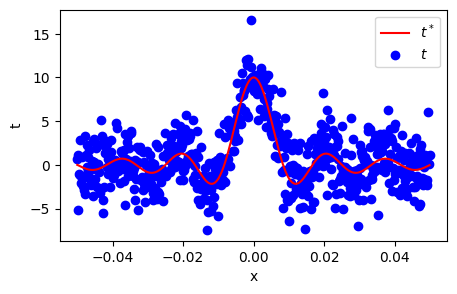

In [ ]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 2 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
# --- Split 70% train / 30% test ---
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


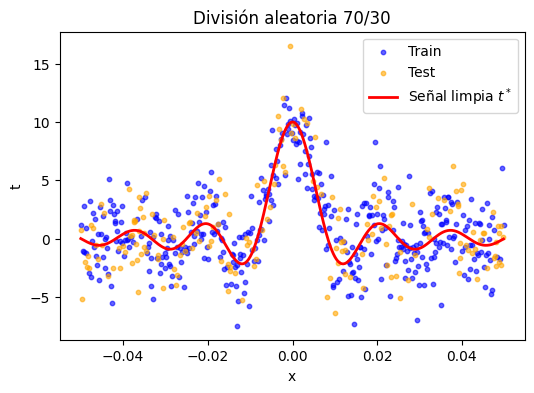

In [ ]:
# --- Visualización ---
plt.figure(figsize=(6,4))
plt.scatter(X_train, t_train, c="blue", s=10, alpha=0.6, label="Train")
plt.scatter(X_test, t_test, c="orange", s=10, alpha=0.6, label="Test")
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("División aleatoria 70/30")
plt.show()


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.89663e-50): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


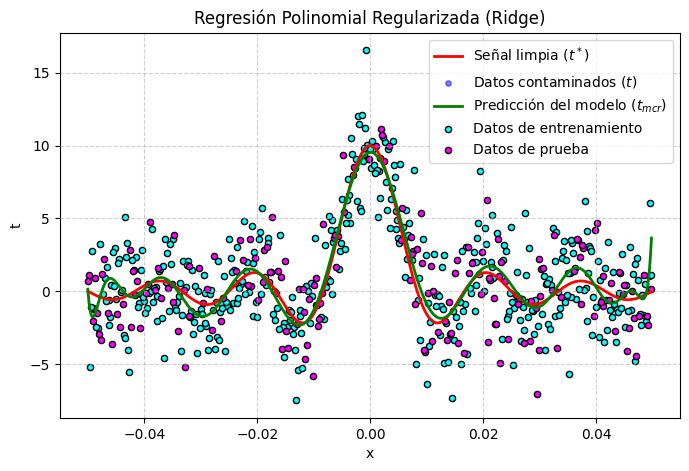

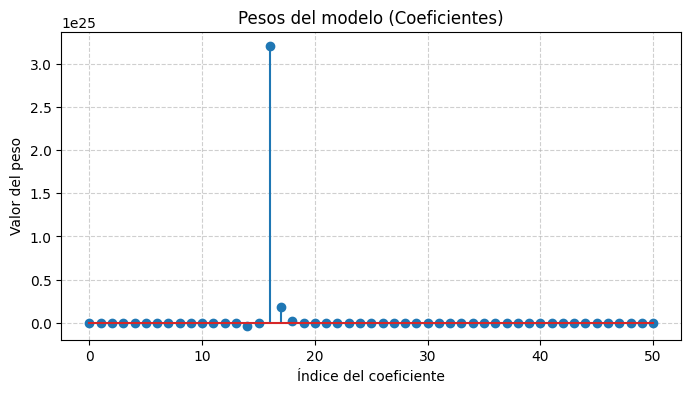

In [ ]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# Generación de la representación polinomial
Q = 50
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X) #

# Particionar datos con 70% train y 30% test
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)

# Obtener los índices para el entrenamiento y la prueba
train_i, test_i = next(rs.split(X))

# Regresor
lambdaR = 1e-50
reg_mc = Ridge(alpha=lambdaR)

# Entrenar el modelo con los datos de entrenamiento
reg_mc.fit(Phi[train_i], t[train_i])

# Realizar predicciones sobre TODO el conjunto de datos para la gráfica
t_mc_pred = reg_mc.predict(Phi)

# --- Graficar ---
plt.figure(figsize=(8, 5))
plt.plot(X, tt, c='r', linewidth=2, label='Señal limpia ($t^*$)')
plt.scatter(X, t, c='b', s=15, alpha=0.5, label='Datos contaminados ($t$)')

# Graficar la predicción completa del modelo sobre todos los puntos
plt.plot(X, t_mc_pred, c='g', linewidth=2, label='Predicción del modelo ($t_{mcr}$)')

# Resaltar los puntos de entrenamiento y prueba
plt.scatter(X[train_i], t[train_i], c='cyan', s=20, edgecolors='k', label='Datos de entrenamiento')
plt.scatter(X[test_i], t[test_i], c='magenta', s=20, edgecolors='k', label='Datos de prueba')

plt.title('Regresión Polinomial Regularizada (Ridge)')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Graficar los pesos del modelo
plt.figure(figsize=(8, 4))
plt.stem(reg_mc.coef_.flatten())
plt.title('Pesos del modelo (Coeficientes)')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del peso')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

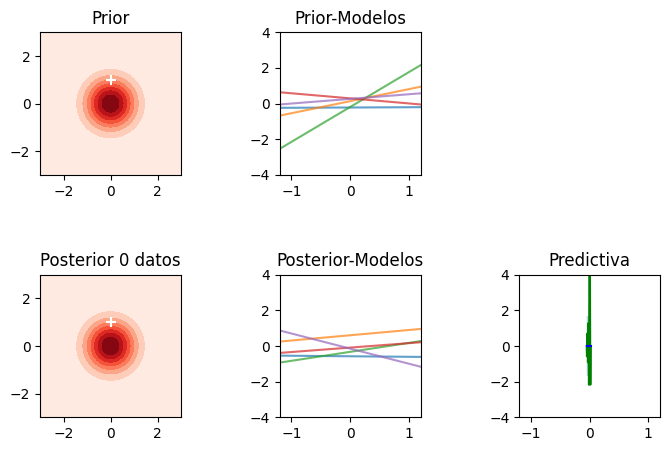

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# ---------- Señal simulada ----------
Fo = 60
A = 10
To = 1/Fo
Fs = 100*Fo
X = np.arange(-3*To, To, 1/Fs)

snrdB = 10
def var_snr(signal, snrdB):
    Ps = np.mean(signal**2)
    Pn = Ps / (10**(snrdB/10))
    return Pn

tt = A*np.sin(2*np.pi*Fo*X)/(2*np.pi*Fo*X)
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

X = X.reshape(-1,1)
t = t.reshape(-1,1)

# ---------- Funciones auxiliares ----------
def my_2Dpdf(mu, Sigma, axes, cmap, xlim, ylim, n=100):
    """Dibuja la pdf 2D gaussiana en el espacio de pesos."""
    from scipy.stats import multivariate_normal
    x = np.linspace(xlim[0], xlim[1], n)
    y = np.linspace(ylim[0], ylim[1], n)
    Xg, Yg = np.meshgrid(x, y)
    pos = np.dstack((Xg, Yg))
    rv = multivariate_normal(mu, Sigma)
    Z = rv.pdf(pos)
    axes.contourf(Xg, Yg, Z, cmap=cmap)

def my_linregsyn(mu, Sigma, axes, xlim, ylim, n_samples=5):
    """Muestra regresores lineales muestreados de la distribución de pesos."""
    ws = np.random.multivariate_normal(mu, Sigma, n_samples)
    xgrid = np.linspace(xlim[0], xlim[1], 50)
    for w in ws:
        ygrid = w[0] + w[1]*xgrid
        axes.plot(xgrid, ygrid, alpha=0.7)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

def my_posterior_update(Xn, tn, sig_eta, sig_w, tol=1e-10):
    """Actualiza posterior bayesiano para regresión lineal."""
    N, D = Xn.shape
    # Agregar bias
    Phi = np.hstack([np.ones((N,1)), Xn])
    S0 = sig_w * np.eye(D+1)
    SN_inv = np.linalg.inv(S0) + (1/sig_eta)*Phi.T @ Phi
    SN = np.linalg.inv(SN_inv + tol*np.eye(D+1))
    mN = (1/sig_eta) * SN @ Phi.T @ tn
    return mN.ravel(), SN

def my_predictiva_update(Xgrid, mN, SN, sig_eta):
    """Distribución predictiva: media y varianza para cada x."""
    Phi = np.hstack([np.ones((Xgrid.shape[0],1)), Xgrid])
    mean = Phi @ mN.reshape(-1,1)
    var = np.sum(Phi @ SN * Phi, axis=1).reshape(-1,1) + sig_eta
    return mean, np.sqrt(var)

# ---------- Parámetros iniciales ----------
ind = np.random.randint(0, X.shape[0], size=X.shape[0])
mu_w = np.array([0.0,0.0])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

sig_eta = 0.2  # varianza del ruido

# "verdaderos" pesos para referencia (lineal ficticia)
w_ = np.array([0.0, 1.0])

wxlim = [-3,3]
wylim = [-3,3]
xlim = [-1.2,1.2]
ylim = [-4,4]

# ---------- Animación ----------
fig, ax = plt.subplots(2, 3,figsize=(8,5))
ax[0,2].axis('off')

def update(i):
    ax[0,0].clear(); ax[0,1].clear()
    ax[1,0].clear(); ax[1,1].clear(); ax[1,2].clear()

    # Prior
    my_2Dpdf(mu_w, S_w, axes=ax[0,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0,1], xlim=xlim, ylim=ylim)

    # Posterior con i datos
    mN,SN = my_posterior_update(X[ind[:i]], t[ind[:i]], sig_eta, sig_w)
    my_2Dpdf(mN, SN, axes=ax[1,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1,1], xlim=xlim, ylim=ylim)
    ax[1,1].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')

    # Pesos reales (referencia)
    ax[1,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')
    ax[0,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')

    # Predictiva
    mnew,snew = my_predictiva_update(X, mN, SN, sig_eta)
    ax[1,2].plot(X[:,0], tt, c='g', label="Señal limpia")
    ax[1,2].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')
    ax[1,2].plot(X[:,0], mnew, c='b', label="Media predictiva")
    ii = np.argsort(X[:,0])
    ax[1,2].fill_between(X[ii,0].ravel(),
                         (mnew[ii] - 2*snew[ii]).ravel(),
                         (mnew[ii] + 2*snew[ii]).ravel(),
                         alpha=0.3)
    ax[1,2].set_xlim(xlim); ax[1,2].set_ylim(ylim)

    # Títulos
    ax[0,0].set_title('Prior')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title(f'Posterior {i} datos')
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7,hspace=0.7)

anim = animation.FuncAnimation(fig, update,
                               frames=np.array([0,1,2,3,5,7,9,10,15,20,25,50,100,250,500]),
                               blit=False)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())


In [ ]:
from sklearn.datasets import fetch_california_housing
N = 1000 # # samples
P = 20 # # features
X, y = fetch_california_housing(return_X_y=True)
print(X.shape,y.shape)

(20640, 8) (20640,)


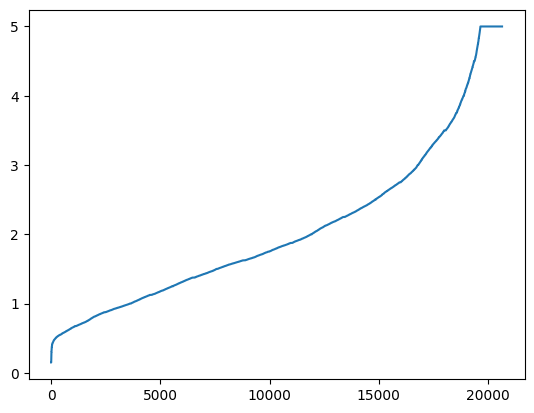

In [ ]:
plt.plot(np.sort(y))
plt.show()

Dimensiones de X (Ingreso Medio): (20640, 1)
Dimensiones de y (Valor de la Vivienda): (20640,)


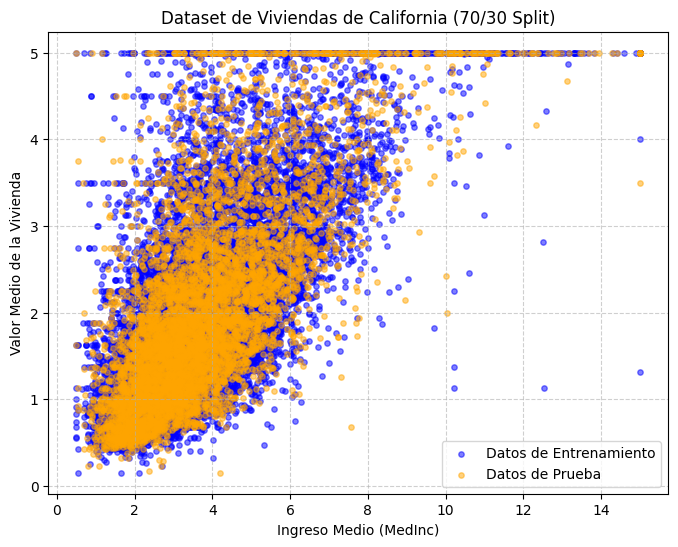

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# --- 1. Cargar y preparar el dataset ---
# Cargamos el dataset de California Housing
X_full, y = fetch_california_housing(return_X_y=True)

# Para poder visualizar en 2D, seleccionamos solo una característica: el Ingreso Medio (MedInc).
# Esta es la primera columna (índice 0).
X = X_full[:, 0].reshape(-1, 1)

print(f"Dimensiones de X (Ingreso Medio): {X.shape}")
print(f"Dimensiones de y (Valor de la Vivienda): {y.shape}")

# --- 2. División 70% entrenamiento / 30% prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Visualización inicial de los datos ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.5, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.5, label="Datos de Prueba")
plt.xlabel("Ingreso Medio (MedInc)")
plt.ylabel("Valor Medio de la Vivienda")
plt.title("Dataset de Viviendas de California (70/30 Split)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Iniciando la búsqueda de los mejores hiperparámetros...
Fitting 4 folds for each of 72 candidates, totalling 288 fits


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56481e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



¡Búsqueda completada!
Mejor grado de polinomio encontrado: 8
Mejor alpha para Ridge encontrado: 0.0052


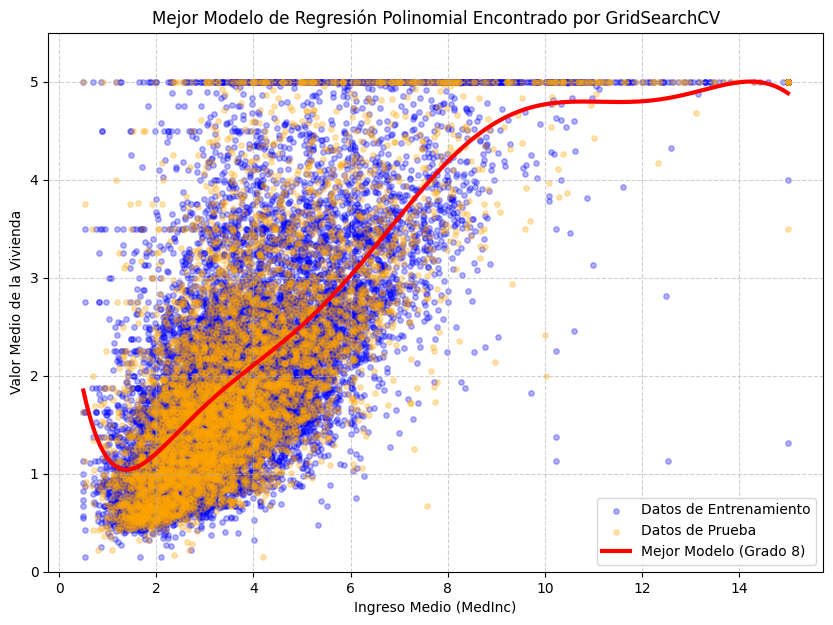


Generando gráficos comparativos para grados específicos...


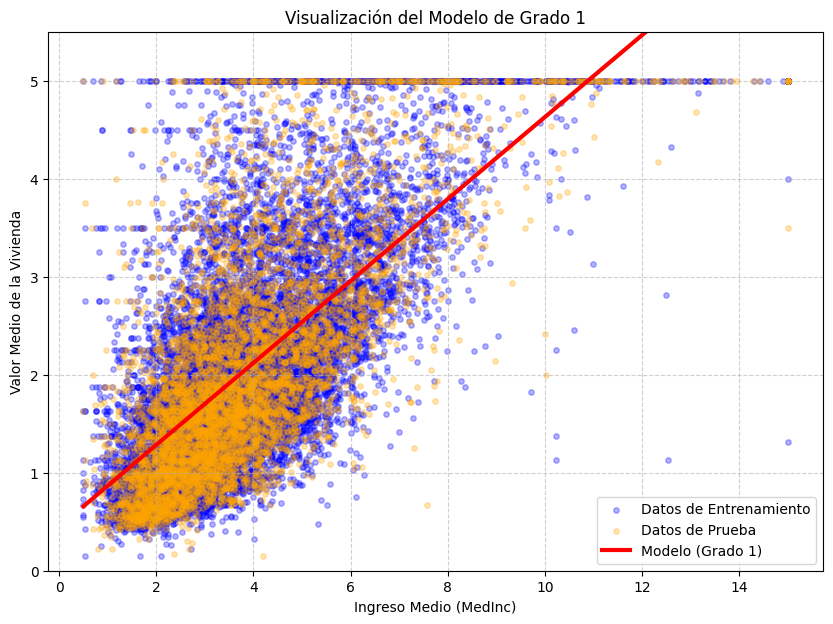

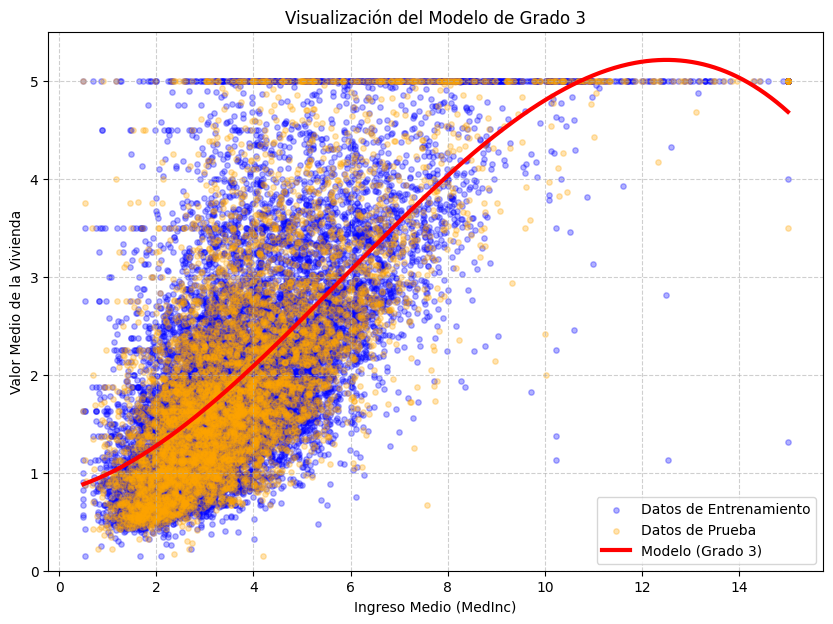

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56481e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


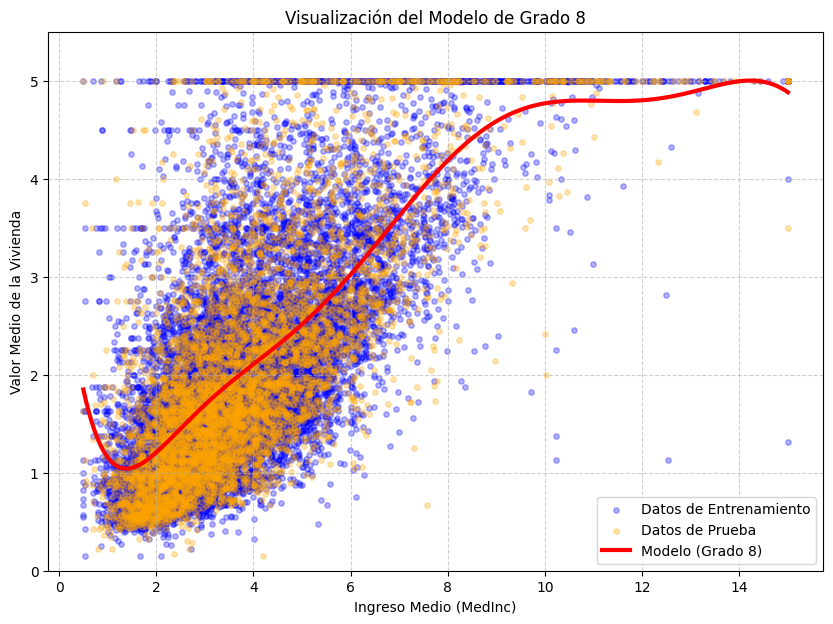

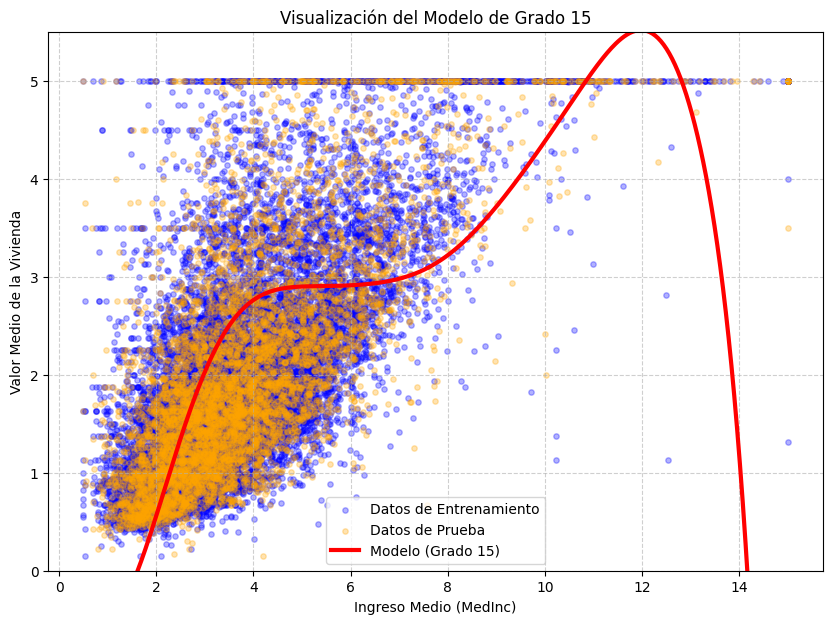

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------------------------
# 1. CARGAR Y PREPARAR LOS DATOS
# ---------------------------------------------------------------------------
X_full, y = fetch_california_housing(return_X_y=True)
X = X_full[:, 0].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# (Opcional) Visualización inicial de los datos
# plt.figure(figsize=(8, 6))
# plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.5, label="Datos de Entrenamiento")
# plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.5, label="Datos de Prueba")
# plt.show()

# ---------------------------------------------------------------------------
# 2. DEFINIR EL PIPELINE Y LA PARRILLA DE PARÁMETROS
# ---------------------------------------------------------------------------
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])
param_grid = {
    'poly__degree': np.arange(1, 10),
    'ridge__alpha': np.logspace(-3, 2, 8)
}

# ---------------------------------------------------------------------------
# 3. EJECUTAR GRIDSEARCHCV CON 4 FOLDS
# ---------------------------------------------------------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=4,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
print("Iniciando la búsqueda de los mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

# ---------------------------------------------------------------------------
# 4. MOSTRAR LOS MEJORES RESULTADOS
# ---------------------------------------------------------------------------
print("\n¡Búsqueda completada!")
best_degree = grid_search.best_params_['poly__degree']
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Mejor grado de polinomio encontrado: {best_degree}")
print(f"Mejor alpha para Ridge encontrado: {best_alpha:.4f}")

best_model = grid_search.best_estimator_

# ---------------------------------------------------------------------------
# 5. VISUALIZAR EL MEJOR MODELO ENCONTRADO
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")
X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
y_range_pred = best_model.predict(X_range)
plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Mejor Modelo (Grado {best_degree})')
plt.title('Mejor Modelo de Regresión Polinomial Encontrado por GridSearchCV')
plt.xlabel('Ingreso Medio (MedInc)')
plt.ylabel('Valor Medio de la Vivienda')
plt.legend()
plt.ylim(0, 5.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# ##############################################################################
# # 6. EXTRA: VISUALIZACIÓN COMPARATIVA DE DIFERENTES GRADOS (NUEVO CÓDIGO)
# ##############################################################################

print("\nGenerando gráficos comparativos para grados específicos...")
# Lista de los grados que quieres visualizar para comparar
grados_a_comparar = [1, 3, best_degree, 15]

for grado in grados_a_comparar:
    # Creamos un modelo específico para este grado
    # Usamos el MEJOR alpha que encontró GridSearchCV para una comparación justa
    modelo_especifico = Pipeline([
        ('poly', PolynomialFeatures(degree=grado, include_bias=False)),
        ('ridge', Ridge(alpha=best_alpha))
    ])

    # Entrenamos este modelo específico
    modelo_especifico.fit(X_train, y_train)

    # Generamos el gráfico
    plt.figure(figsize=(10, 7))
    plt.scatter(X_train, y_train, c="blue", s=15, alpha=0.3, label="Datos de Entrenamiento")
    plt.scatter(X_test, y_test, c="orange", s=15, alpha=0.3, label="Datos de Prueba")

    y_range_pred = modelo_especifico.predict(X_range)

    plt.plot(X_range, y_range_pred, color='red', linewidth=3, label=f'Modelo (Grado {grado})')
    plt.title(f'Visualización del Modelo de Grado {grado}')
    plt.xlabel('Ingreso Medio (MedInc)')
    plt.ylabel('Valor Medio de la Vivienda')
    plt.legend()
    plt.ylim(0, 5.5)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()